# Schematic Reader Project

The purpose of this project is to create a program that can tally up the different types of valves found on a given mechanical system drawing.

This 'Classify' notebook is to convert the images of the valves created by the 'Reader' notebook into a dataframe and train a model to classify the valves. I will manually input the labels for the training set and then use this to identify and count the valves on an un-seen drawing.

#### Future Work:
- Isolating the schematic area from the rest of the drawing
- Improved start position finder
- Multiple start positions once end of line reached
- Identifying and dealing with T's
- Work out how to deal with the same valve drawn in different sizes

#### Import packages

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
import pickle5 as pickle

#### Set whether the Classifier program is in training mode or not i.e. whether we are training the model or not 

In [18]:
training_mode = 0

#### Import the saved images and total from the 'Reader' program and save them with a unique name

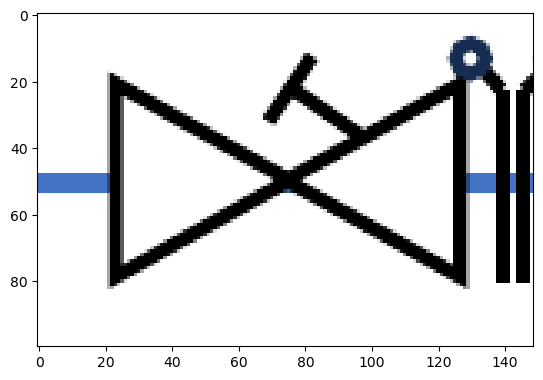

In [19]:
%store -r total


for i in range(1, total + 1):
    name = f'break_{i}'
    
    %store -r {name}


plt.imshow(break_2)
plt.show()

#### Find the dimensions of all valves to find the largest component
[ONLY EXECUTE WHEN IN TRAINING MODE]

In [20]:
if training_mode == 1:
    heights = []
    widths = []

    for x in range(1, total + 1):
        name = f'break_{x}'
        height = globals()[name].shape[0]
        width = globals()[name].shape[1]

        heights.append(height)
        widths.append(width)

    max_height = max(heights)
    max_width = max(widths)

    print(f'Max Height: {max_height}')
    print(f'Max Width: {max_width}')

#### Make all component arrays the same size to avoid NaN's in the DataFrame and center the component within its array

In [21]:
for x in range(1, total + 1):
    name = f'break_{x}'
    
    # Calculate difference in height + width compared to the largest component
    
    height = globals()[name].shape[0]
    width = globals()[name].shape[1]

    height_delta = max_height - height
    width_delta = max_width - width
    
    # Add the correct amount of white pixels to top, bottom and sides

    top = np.full([round(height_delta/2), width, 3], 255)
    bottom = np.full([height_delta - round(height_delta/2), width, 3], 255)

    globals()[name] = np.concatenate((top, globals()[name], bottom), axis=0)

    height = globals()[name].shape[0]

    left = np.full([height, round(width_delta/2), 3], 255)
    right = np.full([height, width_delta - round(width_delta/2), 3], 255)

    globals()[name] = np.concatenate((left, globals()[name], right), axis=1)
    
    width = globals()[name].shape[1]

#### Now convert to DataFrame

In [22]:
df = pd.DataFrame()

for x in range(1, total + 1):
    
    name = f'break_{x}'
    compressed = np.sum(globals()[name],axis = 2) / 3    # Use the mean of all 3 layers for simplicity
    
    
    df = pd.concat([df,pd.DataFrame(compressed.reshape(1,-1))])
    
name_list = []

for i in range(height):
    for j in range(width):
        name_list.append(f'px_{i}_{j}')

df.columns = name_list

X = df.copy()

#### Add column for known valve type
[ONLY EXECUTE WHEN IN TRAINING MODE]

In [23]:
if training_mode == 1:
    df['type'] = [1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,
                 1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,
                 1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1]

    y = df.type

    print(df.head())

#### Split data and create, train, save model
[ONLY EXECUTE WHEN IN TRAINING MODE]

In [25]:
if training_mode == 1:
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.7)

    # Create + Train model

    model = RidgeClassifier()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    print(f'Score: {model.score(X_val, y_val)}')

    # Save model

    pickle.dump(model, open('trained_model.sav', 'wb'))

#### Use the model to tally the valve types

In [28]:
if training_mode == 0:
    model = pickle.load(open('trained_model.sav', 'rb'))

valve_predictions = pd.DataFrame(model.predict(X), columns = ['Type'])

valve_types = {1: 'Isolation Valve',
               2: 'Double Regulating Valve',
               3: 'Water Meter',
               4: 'Single Check Valve',
               5: 'Double Check Valve'}


valve_predictions.Type = valve_predictions.Type.apply(lambda n: valve_types[n])

print(valve_predictions.value_counts())

Type                   
Double Regulating Valve    3
Isolation Valve            3
Double Check Valve         2
Single Check Valve         2
Water Meter                2
dtype: int64
